In [1]:
import json
import pandas as pd 
import ipdb
import os
import pickle as pkl
import os.path as osp
import numpy as np
from PIL import Image


In [2]:
# Load Agniv VITpose-base hico filtering
filter_path = './agniv_pose_filter/hico.npy'
pose_md = np.load(filter_path, allow_pickle=True)
pose_md = pose_md.item()
filter_img_names = {}

print(f'Total images found: {len(pose_md)}')

# Filter out images with < 10 visible keypoints 
kp_thresh = 10

for imgname, pose_num in pose_md.items():
    if pose_num > kp_thresh:
        filter_img_names[imgname] = pose_num
        
print(f'Images after KP filtering: {len(filter_img_names)}')

print(list(filter_img_names.keys())[:5])


Total images found: 9642
Images after KP filtering: 3895
['hake_train2015_HICO_train2015_00005476.jpg', 'hake_train2015_HICO_train2015_00008329.jpg', 'hake_train2015_HICO_train2015_00008027.jpg', 'hake_train2015_HICO_train2015_00013408.jpg', 'hake_train2015_HICO_train2015_00010656.jpg']


In [3]:
# # Load Agniv VITpose-base hot dict
# filter_path = "./agniv_pose_filter/hot_dict.pkl"
# with open(filter_path, 'rb') as f:
#     pose_md_dict = pkl.load(f)
    
# hico_dict = {}

# for k, v in pose_md_dict.items():
#     if 'hake' in k:
#         hico_dict[k] = v
    
# print(f'Total images found: {len(hico_dict)}')

# # Filter out images with < 10 visible keypoints 
# kp_thresh = 10

# filter_img_names = {}

# for imgname, kp_md in hico_dict.items():
#     if kp_md == 0:
#         continue
#     if kp_md["num_persons"] == 1 and kp_md["num_kpt"][0.5][0] > kp_thresh:
#         filter_img_names[imgname] = kp_md["num_kpt"][0.5][0]
        
# print(f'Images after KP filtering: {len(filter_img_names)}')

In [4]:

hico_annot = json.load(open('/ps/project/datasets/HICO/hico-image-level/hico-training-set-image-level.json', 'rb'))
hoi_mapping = pd.read_csv('/ps/project/datasets/HICO/hico-image-level/hico_hoi_list.txt', header=None, delim_whitespace=True)
print(hoi_mapping)

       0         1               2
0      1  airplane           board
1      2  airplane          direct
2      3  airplane            exit
3      4  airplane             fly
4      5  airplane         inspect
..   ...       ...             ...
595  596     zebra            feed
596  597     zebra            hold
597  598     zebra             pet
598  599     zebra           watch
599  600     zebra  no_interaction

[600 rows x 3 columns]


In [5]:
version = '1'
out_dir = f'./filtered_data/v_{version}'
os.makedirs(out_dir, exist_ok=True)

objectwise_img_names = {}
imgwise_object_names = {}
img_dir = '/ps/project/datasets/HICO/hico_20150920/images/train2015'

bad_object_names = ['bear', 'bird', 'cat', 'cow', 
                    'dog', 'elephant', 'giraffe', 'horse', 
                   'mouse', 'person', 'sheep', 'zebra' ]
bad_action_names = ['buy', 'chase', 'direct', 'greet', 'herd', 'hose',
                   'hug', 'hunt', 'milk', 'no_interaction', 'pet', 'point', 'teach',
                   'watch', 'wave']

for i, (img_name, img_md) in enumerate(hico_annot.items()):
    
    # Apply keypoint number filtering on the images 
    full_img_name = 'hake_train2015_' + img_name
    if full_img_name not in filter_img_names.keys():
        continue
    
    # show the image
    if i < 0:
        img = Image.open(osp.join(img_dir,img_name))
        display(img)
    
    obj_names = []
    action_names = []
    kp_num = filter_img_names[full_img_name]
    
    # travel through all hoi in the metadata, save obj_names and action_names for the hois
    for hoi_id in img_md['hoi_id']:
        img_md_row = hoi_mapping.loc[hoi_mapping[0] == hoi_id].iloc[0]

        obj_name = img_md_row[1]
        if obj_name in bad_object_names:
            continue
        action_name = img_md_row[2]
        if action_name in bad_action_names:
            continue
            
        obj_names.append(obj_name)
        action_names.append(action_name)
        
    if len(set(obj_names)) == 0 or len(action_names) == 0:
        continue
    
    imgwise_object_names.setdefault(full_img_name,[]).extend(list(set(obj_names)))
    
# #     # Display images with multiple objects
#     if len(set(obj_names)) > 1:
#         print(img_name)
#         print(obj_names)
#         print(action_names)
#         print(f'Number of Kps: {kp_num}')
#         img = Image.open(osp.join(img_dir,img_name))
#         display(img)
            
    for obj_name in set(obj_names):
        objectwise_img_names.setdefault(obj_name,[]).append(full_img_name)
        
print(f'Final number of images {len(imgwise_object_names)}')

Final number of images 3154


In [6]:
# Save the imagewise_object dict
out_path = osp.join(out_dir, 'object_per_image_dict.json')
with open(out_path, 'w') as fp:
    json.dump(imgwise_object_names, fp)
    print(f'saved at {out_path}')
    
# # save image_list 
# out_path = osp.join(out_dir, 'hico_imglist_all_140223.txt')
# with open(out_path, 'w') as f:
#     f.write('\n'.join(imgwise_object_names.keys()))
#     print(f'saved at {out_path}')


# Save the object_wise dict
out_path = osp.join(out_dir, 'imgnames_per_object_dict.json')
with open(out_path, 'w') as fp:
    json.dump(objectwise_img_names, fp)
    print(f'saved at {out_path}')

    

    

saved at ./filtered_data/v_1/object_per_image_dict.json
saved at ./filtered_data/v_1/imgnames_per_object_dict.json


/home/stripathi/anaconda3/envs/cliff/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


3189


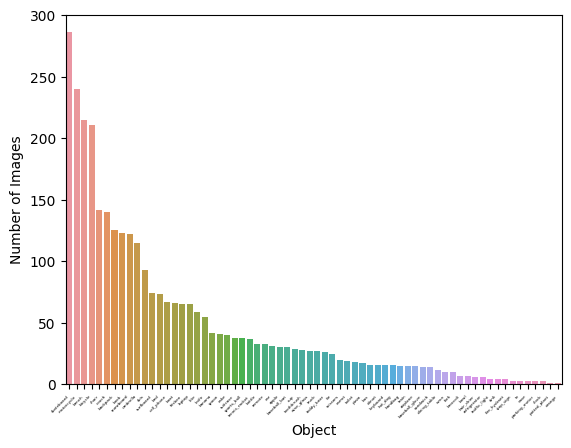

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# sort the dictionary 
objectwise_img_names = dict(sorted(objectwise_img_names.items(), key=lambda x: len(x[1]), reverse=True))

# Extract object names and image counts
obj_names = list(objectwise_img_names.keys())
img_counts = [len(objectwise_img_names[obj]) for obj in objectwise_img_names]
print(sum(img_counts))

# Create bar plot
sns.barplot(x=obj_names, y=img_counts)

# Add x-axis and y-axis labels
plt.xlabel('Object')
plt.ylabel('Number of Images')

plt.xticks(rotation=45, ha='right', fontsize=3)

# Save the plot as a high-resolution image file
out_path = osp.join(out_dir, 'image_per_object_category.png')
plt.savefig(out_path, dpi=300)

# Show plot
plt.show()